## TODO
1. Error bars on cashbuilder by chaser graph.
2. Hypothesis tests for cashbuilder / season progress questions.
3. Ask one of the Chasers on Twitter how the offers are calculated. (The producers probably want to keep it "mysterious", but who knows).
4. Predict: player likelihood of winning, P(W|C=£5000).
5. Predict: team likelihood of winning in the final chase.
6. Use this to get expected loss of the show, how much do they aim to lose.

## Imports / config

In [40]:
import pandas as pd
import re
import collections
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np
from sklearn.linear_model import LinearRegression

plt.style.use('ggplot')

## Useful common stuff

In [2]:
CHASERS = [
    "Mark Labbett",
    "Shaun Wallace",
    "Jenny Ryan",
    "Paul Sinha",
    "Anne Hegerty"
]

## Load the data

In [3]:
episodes = pd.read_csv("episodes.csv", sep=";")
episodes.rename(
    columns={
        "First air date": "AirDate",
        "Amount banked": "Banked",
        "Won head-to-head": "WonHeadToHead"},
    inplace=True)
episodes.loc[episodes['Result'].str.contains('Chaser'), 'ChaserWin'] = True
episodes.loc[episodes['Result'].str.contains('Team'), 'ChaserWin'] = False
episodes.drop(
    columns=["Result", "PushbacksTaken", "PushbacksOffered",
             "Pushforwards", "Players", "Accuracy",
             "Speed", "WonHeadToHead", "Banked", "Target"],
    inplace=True)

In [4]:
hth = pd.read_csv("hth.csv", sep=",")
hth.loc[hth["HTH_Result"] == 0, "Escaped"] = False
hth.loc[hth["HTH_Result"] == 1, "Escaped"] = True
OFFER_REGEX = re.compile(r"-?£[0-9]+(,[0-9]*)?\.[0-9]{2}")
def convert_offer(offer):
    if isinstance(offer, float):
        return offer
    assert OFFER_REGEX.match(offer) is not None
    offer = offer.replace("£", "")
    offer = offer.replace(",", "")
    offer = re.sub('\.[0-9]{2}$', '', offer)
    return float(offer)
for i, row in hth.iterrows():
    hth.at[i, "LowerOffer"] = convert_offer(hth.at[i, "HTH_LowerOffer"])
    hth.at[i, "HigherOffer"] = convert_offer(hth.at[i, "HTH_HigherOffer"])
    if hth.at[i, "HTH_OptionChosen"].startswith("Lower"):
        option = "low"
    elif hth.at[i, "HTH_OptionChosen"].startswith("Middle"):
        option = "mid"
    elif hth.at[i, "HTH_OptionChosen"].startswith("Higher"):
        option = "high"
    else:
        raise Exception("Ruh roh")
    hth.at[i, "OptionChosen"] = option
hth.drop(
    columns=["First air date",
             "HTH_Chaser",
             "Name",
             "HTH_Result",
             "HTH_LowerOffer",
             "HTH_HigherOffer",
             "HTH_OptionChosen",
             "HTH_OfferChosen"],
    inplace=True)
hth.rename(
    columns={
        "Cash builder": "CashBuilder"},
    inplace=True)

## Validate

In [5]:
def assert_no_nans(df, name):
    assert df[name].isna().sum() == 0, f"NaN detected in column {name}"
for name in ["AirDate", "Series", "Episode", "Chaser", "ChaserWin"]:
    assert name in episodes.columns, f"Missing column {name}"
    assert_no_nans(episodes, name)
# Sometimes, no lower offer is made, so we can expect NaNs in that column.
for name in ["Series", "Episode", "Player", "CashBuilder", "Escaped", "HigherOffer", "OptionChosen"]:
    assert name in hth.columns, f"Missing column {name}"
    assert_no_nans(hth, name)
for chaser in episodes["Chaser"]:
    assert chaser in CHASERS, f"Unknown chaser '{chaser}' :_("

## Remove early seasons
Cash builders / the format of the game have been consistent since season 6 onwards, according to: http://www.onequestionshootout.xyz/stats/cashbuilders.htm

So just gonna remove the ones before that.

In [6]:
def remove_seasons_1_to_5(df):
    df.drop(df[df.Series <= 5].index, inplace=True)
remove_seasons_1_to_5(episodes)
remove_seasons_1_to_5(hth)

## Take a look

In [7]:
episodes

,AirDate,Series,Episode,Chaser,ChaserWin
268,29/10/2012,6,1,Mark Labbett,False
269,30/10/2012,6,2,Paul Sinha,True
270,31/10/2012,6,3,Anne Hegerty,True
271,01/11/2012,6,4,Shaun Wallace,False
272,02/11/2012,6,5,Mark Labbett,True
...,...,...,...,...,...
1551,16/03/2020,13,77,Jenny Ryan,True
1552,17/03/2020,13,46,Mark Labbett,True
1553,18/03/2020,13,79,Paul Sinha,True
1554,19/03/2020,13,80,Anne Hegerty,True


In [8]:
hth

,Series,Episode,Player,CashBuilder,Escaped,LowerOffer,HigherOffer,OptionChosen
1072,6,1,1,7,True,2000.0,25000.0,mid
1073,6,1,2,7,True,2000.0,35000.0,mid
1074,6,1,3,4,False,1000.0,35000.0,mid
1075,6,1,4,2,False,-2000.0,46000.0,low
1076,6,2,1,4,False,1000.0,20000.0,mid
...,...,...,...,...,...,...,...,...
6219,13,80,4,2,True,-2000.0,63000.0,low
6220,13,81,1,3,True,550.0,21000.0,mid
6221,13,81,2,7,True,1000.0,30000.0,mid
6222,13,81,3,2,False,-1000.0,40000.0,mid


## Which chaser is "most bankable"?

In [9]:
chaser_by_episode = {}
for i, row in episodes.iterrows():
    chaser_by_episode[(row["Series"], row["Episode"])] = row["Chaser"]
results = []
for chaser in CHASERS:
    count_by_cash = collections.defaultdict(int)
    sum_by_cash = collections.defaultdict(int)
    for i, row in hth.iterrows():
        if (chaser_by_episode[(row["Series"], row["Episode"])] == chaser
                and row["Player"] == 1):
            cash = row["CashBuilder"]
            count_by_cash[cash] += 1
            sum_by_cash[cash] += row["HigherOffer"]
    avg_by_cash = {}
    for cash in count_by_cash:
        avg_by_cash[cash] = sum_by_cash[cash] / count_by_cash[cash]
    results.append((chaser, avg_by_cash))

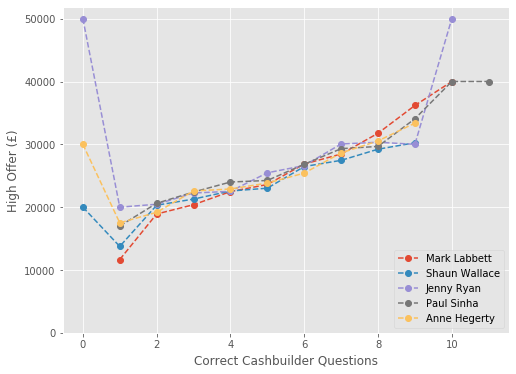

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
for i, (chaser, avg_by_cash) in enumerate(results):
    pairs = list(avg_by_cash.items())
    pairs.sort(key=lambda pair: pair[0])
    plt.plot(
        [cash for cash, avg in pairs],
        [avg for cash, avg in pairs],
        label=chaser,
        marker='o',
        linestyle='dashed')
plt.legend()
plt.ylim(bottom=0)
plt.xlabel("Correct Cashbuilder Questions")
plt.ylabel("High Offer (£)")
plt.savefig("high-offers.png")

## Do offers change over the course of the season?

In [15]:
num_episodes_by_season = {}
for s in range(6, 14):
    num_episodes_by_season[s] = max(
        episodes.loc[episodes["Series"] == s, "Episode"])
offers_by_frac_through_season = collections.defaultdict(list)
for i, row in hth.iterrows():
    fraction_through_season = row["Episode"] / num_episodes_by_season[row["Series"]]
    key = math.floor(fraction_through_season / 0.2001)
    offers_by_frac_through_season[key].append(row["HigherOffer"])

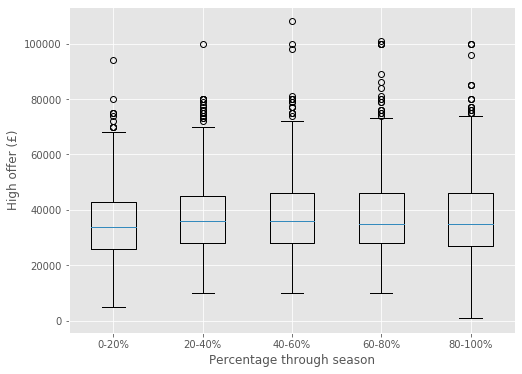

In [16]:
# Divided offers into 5 buckets based on how far they are into
# the season. Now do a boxplot of the offers in each bucket.
fig, ax = plt.subplots(figsize=(8,6))
data = list(offers_by_frac_through_season.items())
data.sort(key=lambda pair: pair[0])
plt.boxplot(
    [pair[1] for pair in data],
    positions=[0, 1, 2, 3, 4],
    labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
plt.xlabel("Percentage through season")
plt.ylabel("High offer (£)")
plt.savefig("offers-over-season.png")

#### Hypothesis test
Fit a linear regression model:

    offer_i = B0 + B1.S_i + B2.C_i + E_i

...where offer_i is the amount offered for the i-th player, S_i is how far they were through the season (as a fraction), C_i is how much that player earned in the cash builder, and E_i is the error term that follows a normal distribution (we assume).

If progress in the season doesn't influence the offer, then we expect B1=0. So that should be the basis of the hypothesis test.

In [46]:
# Get data into the expected format.
# TODO: filter so that it's only the first player.
X = np.array(
        pd.concat(
            [hth["CashBuilder"],
             hth[["Series", "Episode"]].apply(
                 lambda row: row["Episode"]/num_episodes_by_season[row["Series"]],
                 axis=1)],
            axis=1))
y = np.array(hth["HigherOffer"])

print(X)
print(y)

# Fit model.
model = LinearRegression()
model.fit(X, y)

[[7.00000000e+00 6.71140940e-03]
 [7.00000000e+00 6.71140940e-03]
 [4.00000000e+00 6.71140940e-03]
 ...
 [7.00000000e+00 5.15923567e-01]
 [2.00000000e+00 5.15923567e-01]
 [5.00000000e+00 5.15923567e-01]]
[25000. 35000. 35000. ... 30000. 40000. 65000.]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
print(model.coef_)
print(model.intercept_)
print(model.score(X, y))
print(model.predict(X[:1, :]))

[ 485.07165261 1967.90049026]
33988.49124304707
0.006187014577272664
[37397.20019718]


In [37]:
print(num_episodes_by_season)

{6: 149, 7: 150, 8: 146, 9: 190, 10: 190, 11: 170, 12: 170, 13: 157}
